#  Predict the Countries from Capitals

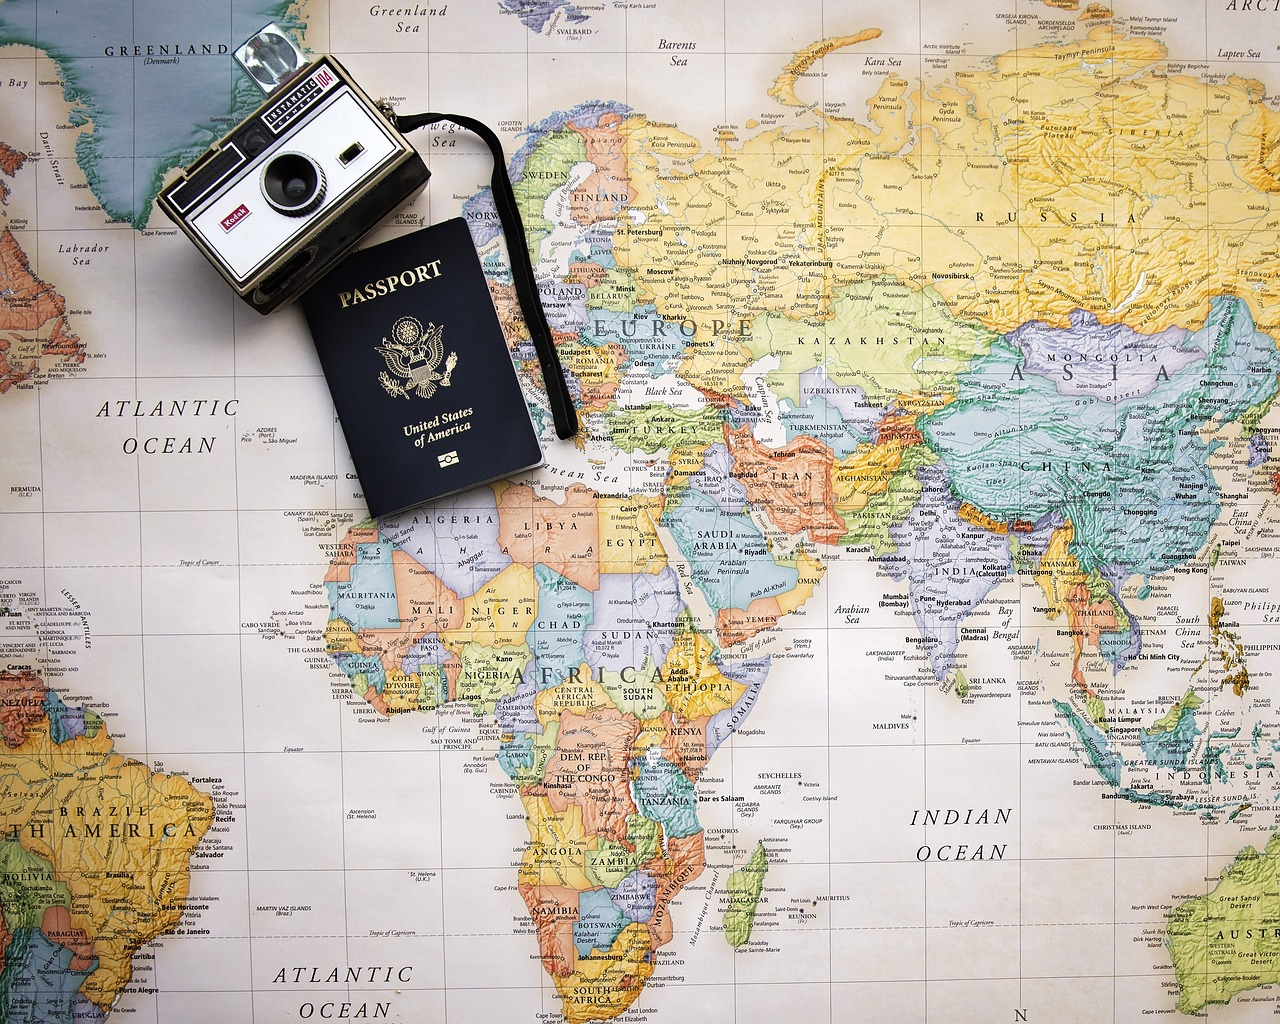


##  Importing Libraries and data


In [1]:
# Run this cell to import packages.
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first ten elements in the DataFrame
data.head(10)

city1 country1      city2     country2
0  Athens   Greece    Bangkok     Thailand
1  Athens   Greece    Beijing        China
2  Athens   Greece     Berlin      Germany
3  Athens   Greece       Bern  Switzerland
4  Athens   Greece      Cairo        Egypt
5  Athens   Greece   Canberra    Australia
6  Athens   Greece      Hanoi      Vietnam
7  Athens   Greece     Havana         Cuba
8  Athens   Greece   Helsinki      Finland
9  Athens   Greece  Islamabad     Pakistan

In [3]:
def get_vectors(embeddings, words):

    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [4]:
def get_word_embeddings(embeddings):

    word_embeddings = {}
    for word in embeddings.vocab:
        if word in set_words:
            word_embeddings[word] = embeddings[word]
    return word_embeddings

We will use The word2vec tool which takes a text corpus as input and produces the word vectors as output
[word2vec](https://code.google.com/archive/p/word2vec/).   
The file :**GoogleNews-vectors-negative300.bin** is available on [word2vec](https://code.google.com/archive/p/word2vec/).


In [5]:

import nltk
from gensim.models import KeyedVectors


embeddings = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
f = open('capitals.txt', 'r').read()
set_words = set(nltk.word_tokenize(f))
select_words = ['king', 'queen', 'oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
for w in select_words:
    set_words.add(w)


In [6]:

# Testing your function
word_embeddings = get_word_embeddings(embeddings)
print(len(word_embeddings))
pickle.dump( word_embeddings, open( "word_embeddings.p", "wb" ) )

243


Now we will load the word embeddings as a Python dictionary

In [7]:
word_embeddings = pickle.load(open("word_embeddings.p", "rb"))
len(word_embeddings)  # there should be 243 words that will be used in this assignment

243

Each of the word embedding is a 300-dimensional vector.

In [8]:
print("dimension: {}".format(word_embeddings['Spain'].shape[0]))

dimension: 300


## Predict relationships among words

Now we will write a function that will use the word embeddings to predict relationships among words.
* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Athens is to Greece as Bangkok is to ______"?



### 1.1 Cosine Similarity

The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector.
& Note that if A and B are identical, you will get $cos(\theta) = 1$.
* Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
* If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
* Numbers between 0 and 1 indicate a similarity score.
* Numbers between -1-0 indicate a dissimilarity score.


In [9]:
def cosine_similarity(A, B):
    
    dot = np.dot(A,B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot/(norma*normb)


    return cos

In [10]:

king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510957

### 1.2 Euclidean distance

You will now implement a function that computes the similarity between two vectors using the Euclidean distance.
Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

* $n$ is the number of elements in the vector
* $A$ and $B$ are the corresponding word vectors. 
* The more similar the words, the more likely the Euclidean distance will be close to 0. 



In [11]:
def euclidean(A, B):

    d = np.linalg.norm (A-B)

    return d


In [12]:
# Test your function
euclidean(king, queen)

2.4796925

### 1.3 Finding the country of each capital

Now, we  will use the previous functions to compute similarities between vectors,
and use these to find the capital cities of countries. 

In [13]:

def get_country(city1, country1, city2, embeddings):

   

    # store the city1, country 1, and city 2 in a set called group
    group = set((city1, country1, city2))

    # get embeddings of city 1
    city1_emb =word_embeddings[city1]

    # get embedding of country 1
    country1_emb =word_embeddings[country1]

    # get embedding of city 2
    city2_emb = word_embeddings[city2]

    # get embedding of country 2 (it's a combination of the embeddings of country 1, city 1 and city 2)
    # Remember: King - Man + Woman = Queen
    vec = country1_emb-city1_emb+city2_emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    similarity = -1

    # initialize country to an empty string
    country = ''

    # loop through all words in the embeddings dictionary
    for word in embeddings.keys():

        # first check that the word is not already in the 'group'
        if word not in group:

            # get the word embedding
            word_emb = word_embeddings[word]

            # calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
            cur_similarity = cosine_similarity(vec,word_emb)

            # if the cosine similarity is more similar than the previously best similarity...
            if cur_similarity > similarity:

                # update the similarity to the new, better similarity
                similarity = cur_similarity

                # store the country as a tuple, which contains the word and the similarity
                country = (word, similarity)


    return country

In [14]:
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

### 1.4 Model Accuracy

Now we will test our new function on the dataset and check the accuracy of the model:

$$\text{Accuracy}=\frac{\text{Correct # of predictions}}{\text{Total # of predictions}}$$


In [15]:
def get_accuracy(word_embeddings, data):

    # initialize num correct to zero
    num_correct = 0

    # loop through the rows of the dataframe
    for i, row in data.iterrows():
       
        # get city1
        city1 = row['city1']

        # get country1
        country1 = row['country1']

        # get city2
        city2 =  row['city2']

        # get country2
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings)

        # if the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # increment the number of correct by 1
            num_correct += 1

    # get the number of rows in the data dataframe (length of dataframe)
    m = len(data)

    # calculate the accuracy by dividing the number correct by m
    accuracy = num_correct/m

    return accuracy


In [16]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


# Plotting the vectors using PCA

Now we will explore the distance between word vectors after reducing their dimension.
The technique we will employ is known as
[*principal component analysis* (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).

The steps to compute PCA are as follows:

1. Mean normalize the data
2. Compute the covariance matrix of your data ($\Sigma$). 
3. Compute the eigenvectors and the eigenvalues of your covariance matrix
4. Multiply the first K eigenvectors by your normalized data. 



In [17]:
def compute_pca(X, n_components=2):


    # mean center the data
    X_demeaned =X-np.mean(X, axis=0,keepdims=True) 

    # calculate the covariance matrix
    covariance_matrix =  np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs =  np.linalg.eigh(covariance_matrix, UPLO='L')

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
    
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted =eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,:n_components]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.transpose(np.dot(np.transpose(eigen_vecs_subset),np.transpose(X_demeaned)))


    return X_reduced


In [18]:
# Testing your function
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_pca(X, n_components=2)
print("Your original matrix was " + str(X.shape) + " and it became:")
print(X_reduced)

Your original matrix was (3, 10) and it became:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [19]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


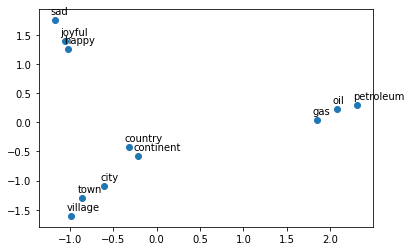

In [20]:
# We have done the plotting for you. Just run this cell.
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()

We notice that the word vectors for 'gas', 'oil' and 'petroleum' appear related to each other,
because their vectors are close to each other.  Similarly, 'sad', 'joyful'
and 'happy' all express emotions, and are also near each other.